In [1]:
from tensorflow.keras.datasets import cifar10, mnist
from scipy import ndimage
import numpy as np
import tensorflow as tf
import tensorflow.keras as keras
from tensorflow.keras import regularizers
from tensorflow.keras import losses
from tensorflow.keras import metrics
from tensorflow.keras import datasets, layers, models
from tensorflow.keras.utils import to_categorical

In [39]:
# code modified from  https://github.com/p-lambda/gradual_domain_adaptation

# helper functions
def get_preprocessed_cifar10():
    (train_x, train_y), (test_x, test_y) = cifar10.load_data()
    train_x, test_x = train_x / 255.0, test_x / 255.0
    train_x, train_y = shuffle(train_x, train_y)
    train_y = to_categorical(train_y)
    test_y = to_categorical(test_y)
    #train_x = np.expand_dims(np.array(train_x), axis=-1)
    #test_x = np.expand_dims(np.array(test_x), axis=-1)
    return (train_x, train_y), (test_x, test_y)

def get_preprocessed_mnist():
    (train_x, train_y), (test_x, test_y) = mnist.load_data()
    train_x, test_x = train_x / 255.0, test_x / 255.0
    train_x, train_y = shuffle(train_x, train_y)
    train_y = to_categorical(train_y)
    test_y = to_categorical(test_y)
    train_x = np.expand_dims(np.array(train_x), axis=-1)
    test_x = np.expand_dims(np.array(test_x), axis=-1)
    return (train_x, train_y), (test_x, test_y)

def continually_rotate_images(xs, start_angle, end_angle):
    new_xs = []
    num_points = xs.shape[0]
    for i in range(num_points):
        angle = float(end_angle - start_angle) / num_points * i + start_angle
        img = ndimage.rotate(xs[i], angle, reshape=False)
        new_xs.append(img)
    return np.array(new_xs)

def sample_rotate_images(xs, start_angle, end_angle):
    new_xs = []
    num_points = xs.shape[0]
    for i in range(num_points):
        if start_angle == end_angle:
            angle = start_angle
        else:
            angle = np.random.uniform(low=start_angle, high=end_angle)
        img = ndimage.rotate(xs[i], angle, reshape=False)
        new_xs.append(img)
    return np.array(new_xs)

def _transition_rotation_dataset(train_x, train_y, test_x, test_y,
                                 source_angles, target_angles, inter_func,
                                 src_train_end, src_val_end, inter_end, target_end):
    assert(target_end <= train_x.shape[0])
    assert(train_x.shape[0] == train_y.shape[0])
    src_tr_x, src_tr_y = train_x[:src_train_end], train_y[:src_train_end]
    src_tr_x = sample_rotate_images(src_tr_x, source_angles[0], source_angles[1])
    src_val_x, src_val_y = train_x[src_train_end:src_val_end], train_y[src_train_end:src_val_end]
    src_val_x = sample_rotate_images(src_val_x, source_angles[0], source_angles[1])
    tmp_inter_x, inter_y = train_x[src_val_end:inter_end], train_y[src_val_end:inter_end]
    inter_x = inter_func(tmp_inter_x)
    dir_inter_x = sample_rotate_images(tmp_inter_x, target_angles[0], target_angles[1])
    dir_inter_y = np.array(inter_y)
    # dir is the "intermediate" samples directly shifted to the target angles (as comparison)
    assert(inter_x.shape == dir_inter_x.shape)
    trg_val_x, trg_val_y = train_x[inter_end:target_end], train_y[inter_end:target_end]
    trg_val_x = sample_rotate_images(trg_val_x, target_angles[0], target_angles[1])
    trg_test_x, trg_test_y = test_x, test_y
    trg_test_x = sample_rotate_images(trg_test_x, target_angles[0], target_angles[1])
    return (src_tr_x, src_tr_y, src_val_x, src_val_y, inter_x, inter_y,
            dir_inter_x, dir_inter_y, trg_val_x, trg_val_y, trg_test_x, trg_test_y)
    

def make_rotated_dataset(train_x, train_y, test_x, test_y,
                         source_angles, inter_angles, target_angles,
                         src_train_end, src_val_end, inter_end, target_end):
    inter_func = lambda x: continually_rotate_images(x, inter_angles[0], inter_angles[1])
    return _transition_rotation_dataset(
        train_x, train_y, test_x, test_y, source_angles, target_angles,
        inter_func, src_train_end, src_val_end, inter_end, target_end)
    
def tweak_one_shift(x, y, rho):
    # assign class "3" probability rho - i started with 0 but realized that doesn't composite well w rotation...
    # since 0 rotated is still 0...
    # evenly distribute among the other classes
    # y is categorical, first reverse to numerical
    y_num = np.argmax(y, axis=1)
    x_res_list = []
    y_res_list = []
    n_total = x.shape[0]
    n_classes = 10
    n_others = int((1-rho)*n_total/(n_classes-1))
    n_chosen = n_total - n_others*(n_classes-1)
    # sample from zero class
    zero_idxs = np.argwhere(y_num == 7)[:, 0]
    zero_chosen = np.random.choice(zero_idxs, n_chosen)
    x_res_list.append(x[zero_chosen])
    y_res_list.append(y[zero_chosen])
    for i in [0,1,2,3,4,5,6,8,9]:
        cur_idxs = np.argwhere(y_num == i)[:,0]
        cur_selected = np.random.choice(cur_idxs, n_others)
        x_res_list.append(x[cur_selected])
        y_res_list.append(y[cur_selected])
    x_res = np.concatenate(x_res_list,axis=0)
    y_res = np.concatenate(y_res_list,axis=0)
    # shuffle
    shuffled_idx = np.arange(x_res.shape[0])
    np.random.shuffle(shuffled_idx)
    x_res_shuffled = x_res[shuffled_idx]
    y_res_shuffled = y_res[shuffled_idx]
    return x_res_shuffled, y_res_shuffled

def resample_class_dist(x, y, p_vec): # the p_vec could be e.g. drawn from Dirichlet dist.
    n_total = x.shape[0]
    y_ordinal = np.argmax(y,axis=1)
    px_counts = np.array(p_vec) * n_total
    x_res_list = []
    y_res_list = []
    for i in range(10):
        cur_idxs = np.argwhere(y_ordinal == i)[:,0]
        #print(cur_idxs)
        if len(cur_idxs) == 0:
            continue
        cur_selected = np.random.choice(cur_idxs, int(px_counts[i]))
        x_res_list.append(x[cur_selected])
        y_res_list.append(y[cur_selected])
    x_res = np.concatenate(x_res_list,axis=0)
    y_res = np.concatenate(y_res_list,axis=0)
    # shuffle
    shuffled_idx = np.arange(x_res.shape[0])
    np.random.shuffle(shuffled_idx)
    x_res_shuffled = x_res[shuffled_idx]
    y_res_shuffled = y_res[shuffled_idx]
    return x_res_shuffled, y_res_shuffled

def rotated_cifar10_20_data_func_nols():
    (train_x, train_y), (test_x, test_y) = get_preprocessed_cifar10()
    return make_rotated_dataset(
        train_x, train_y, test_x, test_y, [0.0, 2.0], [2.0, 20.0], [18.0, 20.0],
        25000, 26000, 48000, 50000)

def rotated_mnist_90_data_func_nols():
    (train_x, train_y), (test_x, test_y) = get_preprocessed_mnist()
    return make_rotated_dataset(
        train_x, train_y, test_x, test_y, [0.0, 9.0], [9.0, 90.0], [81.0, 90.0],
        5000, 6000, 48000, 50000)

'''
def rotated_cifar10_60_data_func_tweakone(interval, target_rho, source_rho = 0.1):
    # interval is the granularity of label shift (change rho of shift per interval)
    (train_x, train_y), (test_x, test_y) = get_preprocessed_cifar10()
    (src_tr_x, src_tr_y, src_val_x, src_val_y, inter_x, inter_y,
     dir_inter_x, dir_inter_y, trg_val_x, trg_val_y, trg_test_x, trg_test_y) = make_rotated_dataset(
        train_x, train_y, test_x, test_y, [0.0, 2.0], [2.0, 20.0], [18.0, 20.0],
        25000, 26000, 48000, 50000)
    # add label shift
    # for intermediate images we also introduce intermediate shift with granularity of interval
    n_batches = int(inter_x.shape[0]/interval)+1
    rho_list = np.linspace(source_rho, target_rho, n_batches)
    inter_x_labelshifted = []
    inter_y_labelshifted = []
    for i in range(n_batches):
        if (i+1)*interval <= inter_x.shape[0]:
            cur_x = inter_x[i*interval:(i+1)*interval]
            cur_y = inter_y[i*interval:(i+1)*interval]
        else:
            cur_x = inter_x[i*interval:]
            cur_y = inter_y[i*interval:]
        cur_shifted_x, cur_shifted_y = tweak_one_shift(cur_x, cur_y, rho_list[i])
        inter_x_labelshifted.append(cur_shifted_x)
        inter_y_labelshifted.append(cur_shifted_y)
    inter_x_ls = np.concatenate(inter_x_labelshifted, axis=0)
    inter_y_ls = np.concatenate(inter_y_labelshifted, axis=0)
    
    # dir_inter_x and dir_inter_y are for comparison (directly self-train on target)
    dir_inter_x_ls, dir_inter_y_ls = tweak_one_shift(dir_inter_x, dir_inter_y, target_rho)

    # shift all of trg_val_x, trg_val_y, trg_test_x, trg_test_y
    trg_val_x_ls, trg_val_y_ls = tweak_one_shift(trg_val_x, trg_val_y, target_rho)
    trg_test_x_ls, trg_test_y_ls = tweak_one_shift(trg_test_x, trg_test_y, target_rho)

    return (src_tr_x, src_tr_y, src_val_x, src_val_y, inter_x_ls, inter_y_ls,
            dir_inter_x_ls, dir_inter_y_ls, trg_val_x_ls, trg_val_y_ls, trg_test_x_ls, trg_test_y_ls)
'''    

def rotated_mnist_90_data_func_dirichlet(interval, alpha, n_classes=10):
    # interval is the granularity of x|y shift
    # x|y shift is gradual, but each step we have arbitrary label shift
    # return array of all dist vecs to get oracle training
    (train_x, train_y), (test_x, test_y) = get_preprocessed_mnist()
    (src_tr_x, src_tr_y, src_val_x, src_val_y, inter_x, inter_y,
     dir_inter_x, dir_inter_y, trg_val_x, trg_val_y, trg_test_x, trg_test_y) = make_rotated_dataset(
        train_x, train_y, test_x, test_y, [0.0, 9.0], [9.0, 90.0], [81.0, 90.0],
        5000, 6000, 48000, 50000)
    # add label shift
    # for intermediate images, each step introduce arbitrary shift
    n_batches = int(inter_x.shape[0]/interval)
    inter_x_labelshifted = []
    inter_y_labelshifted = []
    dist_store = np.zeros((n_batches+1, n_classes))
    for i in range(n_batches):
        if i == 0:
            cur_prob = np.ones(n_classes)/n_classes # start with uniform, no need to correct on first step
        else:
            cur_prob = np.random.dirichlet(np.array([alpha]*n_classes))
        dist_store[i,:] = cur_prob
        if (i+1)*interval <= inter_x.shape[0]:
            cur_x = inter_x[i*interval:(i+1)*interval]
            cur_y = inter_y[i*interval:(i+1)*interval]
        else:
            cur_x = inter_x[i*interval:]
            cur_y = inter_y[i*interval:]
        cur_shifted_x, cur_shifted_y = resample_class_dist(cur_x, cur_y, cur_prob)
        inter_x_labelshifted.append(cur_shifted_x)
        inter_y_labelshifted.append(cur_shifted_y)
    inter_x_ls = np.concatenate(inter_x_labelshifted, axis=0)
    inter_y_ls = np.concatenate(inter_y_labelshifted, axis=0)
    
    final_px = np.random.dirichlet(np.array([alpha]*n_classes))
    dist_store[n_batches,:] = final_px
    # dir_inter_x and dir_inter_y are for comparison (directly self-train on target)
    dir_inter_x_ls, dir_inter_y_ls = resample_class_dist(dir_inter_x, dir_inter_y, final_px)
    
    # shift all of trg_val_x, trg_val_y, trg_test_x, trg_test_y
    trg_val_x_ls, trg_val_y_ls = resample_class_dist(trg_val_x, trg_val_y, final_px)
    trg_test_x_ls, trg_test_y_ls = resample_class_dist(trg_test_x, trg_test_y, final_px)
    return (src_tr_x, src_tr_y, src_val_x, src_val_y, inter_x_ls, inter_y_ls,
            dir_inter_x_ls, dir_inter_y_ls, trg_val_x_ls, trg_val_y_ls, trg_test_x_ls, trg_test_y_ls, dist_store)



In [44]:
tryx = np.array([1,1,2,2,2,2,3,3,4,5]).reshape(-1,1)
tryy = np.zeros((tryx.shape[0],10))
tryy[np.arange(tryy.shape[0]),tryx.flatten()] = 1
newx, newy = resample_class_dist(tryx, tryy, [0.1,0.2,0.1,0.1,0.5,0,0,0,0,0])

In [3]:

class DROLoss(losses.Loss):
    def __init__(self, reduction=keras.losses.Reduction.AUTO, n_groups=10, step_size=0.003, name="droloss"):
        
        self.n_groups = n_groups
        self.step_size = step_size
        self.ori_loss = keras.losses.categorical_crossentropy
        self.group_weights = tf.ones(self.n_groups)/self.n_groups
        #self._name_scope="droloss"
        super().__init__(reduction=reduction, name=name)
    
    def reset_groupweights(self):
        self.group_weights = tf.ones(self.n_groups)/self.n_groups

    def compute_group_avg(self, losses, group_idx):
        group_map = tf.transpose(tf.reshape(group_idx,[-1,1])==tf.range(self.n_groups))#want a matrix of ngroups*nsamples, each entry is 0/1
        group_map = tf.cast(group_map, tf.float32)
        group_count = tf.reduce_sum(group_map,axis=1)
        group_denom = group_count + tf.cast((group_count==0),tf.float32) # avoid nans
        agg_loss = group_map @ tf.reshape(losses,[-1,1])
        
        # without correction, rare classes almost always get 0, which translates to downweight
        # correct 0's to the mean
        cur_mean = tf.reduce_mean(agg_loss)
        #print(agg_loss)
        agg_loss_corrected = agg_loss + tf.cast((agg_loss==0),tf.float32)*cur_mean
        group_loss = tf.reshape(agg_loss_corrected,[-1])/group_denom
        #print(group_loss)
        return group_loss, group_count

    def robust_loss(self, yhat, y, group_idx): # groups idx is size of batch size, each entry 0,...9
        per_sample_losses = self.ori_loss(y, yhat)
        group_loss, group_count = self.compute_group_avg(per_sample_losses, group_idx)
        adjusted_loss = group_loss # no adjustment for now
        # update weight
        self.group_weights = self.group_weights * tf.exp(self.step_size*adjusted_loss)
        self.group_weights = self.group_weights/tf.reduce_sum(self.group_weights)

        rloss = tf.reduce_sum(group_loss * self.group_weights)*self.n_groups
        return rloss

    def call(self, ytrue, ypred):
        return self.robust_loss(ytrue, ypred, tf.argmax(ytrue,1,output_type=tf.dtypes.int32))



In [45]:
# training functions
def self_train_once(student, teacher, unsup_x, confidence_q=0.1, epochs=10, class_ws=None):
    # Do one bootstrapping step on unsup_x, where pred_model is used to make predictions,
    # and we use these predictions to update model.
    logits = teacher.predict(np.concatenate([unsup_x]))
    confidence = np.amax(logits, axis=1) - np.amin(logits, axis=1)
    alpha = np.quantile(confidence, confidence_q)
    indices = np.argwhere(confidence >= alpha)[:, 0]
    preds = np.argmax(logits, axis=1)
    preds = to_categorical(preds, num_classes=10)
    # apply class weights
    if class_ws is not None:
        # get class ws dict
        cw = {}
        for i in range(10):
            cw[i] = class_ws[i]
        student.fit(unsup_x[indices], preds[indices], epochs=epochs, class_weight = cw, verbose=False)
    else:
        student.fit(unsup_x[indices], preds[indices], epochs=epochs, verbose=False)

def soft_self_train_once(student, teacher, unsup_x, epochs=100):
    probs = teacher.predict(np.concatenate([unsup_x]))
    student.fit(unsup_x, probs, epochs=epochs, verbose=False)

def self_train(teacher, unsup_x, confidence_q=0.1, epochs=100, repeats=1,
               target_x=None, target_y=None, soft=False):
    accuracies = []
    student = teacher
    for i in range(repeats):
        if soft:
            soft_self_train_once(student, teacher, unsup_x, epochs)
        else:
            self_train_once(student, teacher, unsup_x, confidence_q, epochs)
        if target_x is not None and target_y is not None:
            _, accuracy = student.evaluate(target_x, target_y, verbose=True)
            accuracies.append(accuracy)
        teacher = student
    return accuracies, student

def gradual_self_train(teacher, unsup_x, debug_y, interval, confidence_q=0.1,
                       epochs=100, soft=False):
    upper_idx = int(unsup_x.shape[0] / interval)
    accuracies = []
    student = teacher
    for i in range(upper_idx):
        cur_xs = unsup_x[interval*i:interval*(i+1)]
        cur_ys = debug_y[interval*i:interval*(i+1)]
        # _, student = self_train(
        #     student_func, teacher, unsup_x, confidence_q, epochs, repeats=2)
        if soft:
            soft_self_train_once(student, teacher, cur_xs, epochs)
        else:
            self_train_once(student, teacher, cur_xs, confidence_q, epochs)
        _, accuracy = student.evaluate(cur_xs, cur_ys)
        accuracies.append(accuracy)
        teacher = student
    return accuracies, student

def gradual_gdro_self_train(teacher, loss, unsup_x, debug_y, interval, diststore, confidence_q=0.1,
                       epochs=100, soft=False):
    upper_idx = int(unsup_x.shape[0] / interval)
    accuracies = []
    student = teacher
    for i in range(upper_idx):
        cur_xs = unsup_x[interval*i:interval*(i+1)]
        cur_ys = debug_y[interval*i:interval*(i+1)]
        # _, student = self_train(
        #     student_func, teacher, unsup_x, confidence_q, epochs, repeats=2)
        print(loss.group_weights)
        print("new dist")
        print(diststore[i,:])
        loss.reset_groupweights()
        if soft:
            soft_self_train_once(student, teacher, cur_xs, epochs)
        else:
            self_train_once(student, teacher, cur_xs, confidence_q, epochs)
        _, accuracy = student.evaluate(cur_xs, cur_ys)
        accuracies.append(accuracy)
        teacher = student
    return accuracies, student

def gradual_corrected_self_train(teacher, unsup_x, debug_y, interval, dist_store, confidence_q=0.1,
                       epochs=100, soft=False):
    upper_idx = int(unsup_x.shape[0] / interval)
    accuracies = []
    student = teacher
    for i in range(upper_idx):
        cur_xs = unsup_x[interval*i:interval*(i+1)]
        cur_ys = debug_y[interval*i:interval*(i+1)]
       
        # weight by distance store
        #class_ws = dist_store[i+1,:]/dist_store[i,:]
        # normalize
        #class_ws = class_ws / np.mean(class_ws)
        # resample
        cur_resampled_x, cur_resampled_y = resample_class_dist(cur_xs, cur_ys, dist_store[i+1,:])
        if soft:
            soft_self_train_once(student, teacher, cur_resampled_x, epochs)
        else:
            self_train_once(student, teacher, cur_resampled_x, confidence_q, epochs)
        _, accuracy = student.evaluate(cur_resampled_x, cur_resampled_y)
        accuracies.append(accuracy)
        teacher = student
    return accuracies, student

In [5]:
# model
from keras.models import Sequential
from keras.layers import Conv2D
from keras.layers import MaxPooling2D
from keras.layers import Dense
from keras.layers import Flatten
from tensorflow.keras.optimizers import SGD
'''
def simple_softmax_conv_model():
    model = Sequential()

    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu', input_shape=(32,32,3)))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(32, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.3))

    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(64, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.5))

    model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Conv2D(128, (3,3), padding='same', activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.MaxPooling2D(pool_size=(2,2)))
    model.add(layers.Dropout(0.5))

    model.add(layers.Flatten())
    model.add(layers.Dense(128, activation='relu'))
    model.add(layers.BatchNormalization())
    model.add(layers.Dropout(0.5))
    model.add(layers.Dense(10, activation='softmax')) 
    # compile model
    
    model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
    return model
'''
def simple_softmax_conv_model(num_labels=10, hidden_nodes=32, input_shape=(28,28,1), l2_reg=0.0):
    model = keras.models.Sequential([
    keras.layers.Conv2D(hidden_nodes, (5,5), (2, 2), activation=tf.nn.relu,
                           padding='same', input_shape=input_shape),
    keras.layers.Conv2D(hidden_nodes, (5,5), (2, 2), activation=tf.nn.relu,
                           padding='same'),
    keras.layers.Conv2D(hidden_nodes, (5,5), (2, 2), activation=tf.nn.relu,
                           padding='same'),
    keras.layers.Dropout(0.5),
    keras.layers.BatchNormalization(),
    keras.layers.Flatten(name='after_flatten'),
    # keras.layers.Dense(64, activation=tf.nn.relu),
    keras.layers.Dense(num_labels, activation=tf.nn.softmax, name='out')
    ])
    return model

In [6]:
def rand_seed(seed):
    np.random.seed(seed)
    tf.compat.v1.set_random_seed(seed)

def shuffle(xs, ys):
    indices = list(range(len(xs)))
    np.random.shuffle(indices)
    return xs[indices], ys[indices]

In [50]:
def exp(seed, label_shift, tweak_one_rho = None, dirichlet_alpha = None, interval=2000, epochs=10, conf_q=0.1, n_classes=10):
    # get data
    if label_shift == "NO_LS":
        (src_tr_x, src_tr_y, src_val_x, src_val_y, inter_x, inter_y, dir_inter_x, dir_inter_y,
         trg_eval_x, trg_eval_y, trg_test_x, trg_test_y) = rotated_mnist_90_data_func_nols()
        n_batches = int(inter_x.shape[0]/interval)
        diststore = np.ones((n_batches+1, n_classes))
    elif label_shift == "TWEAK_ONE":
        if tweak_one_rho is None:
            print("no tweak one rho!")
            return
        (src_tr_x, src_tr_y, src_val_x, src_val_y, inter_x, inter_y, dir_inter_x, dir_inter_y,
         trg_eval_x, trg_eval_y, trg_test_x, trg_test_y) = rotated_mnist_90_data_func_tweakone(interval, tweak_one_rho)
    elif label_shift == "DIRICHLET":
        if dirichlet_alpha is None:
            print("no dirichlet alpha!")
            return
        (src_tr_x, src_tr_y, src_val_x, src_val_y, inter_x, inter_y, dir_inter_x, dir_inter_y,
         trg_eval_x, trg_eval_y, trg_test_x, trg_test_y, diststore) = rotated_mnist_90_data_func_dirichlet(interval, dirichlet_alpha)
        
        #print(diststore)
    # set seed
    rand_seed(seed)
    
    # Train source model
    source_model = simple_softmax_conv_model()
    source_model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
    source_model.fit(src_tr_x, src_tr_y, epochs=epochs, verbose=False)
    _, src_acc = source_model.evaluate(src_val_x, src_val_y)
    _, srcmodel_acc = source_model.evaluate(trg_eval_x, trg_eval_y)

    # corrected gradual self training (assuming we know label shift)
    
    if label_shift != "NO_LS":
        print("\n\n Gradual corrected self-training:")
        teacher = simple_softmax_conv_model()
        teacher.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'])
        teacher.set_weights(source_model.get_weights())
        gradual_corrected_accuracies, student = gradual_corrected_self_train(teacher, inter_x, inter_y, interval, diststore, epochs=epochs,
            confidence_q=conf_q)
        _, cacc = student.evaluate(trg_eval_x, trg_eval_y)
        gradual_corrected_accuracies.append(cacc)
    
    # Train directly on target (oracle)
    # know it's good
    '''
    print("\n\n Direct train on target:")
    target_model = simple_softmax_conv_model()
    target_model.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'], run_eagerly=True)
    target_model.fit(dir_inter_x, dir_inter_y, epochs=epochs, verbose=False)
    _, oracle_target_acc = target_model.evaluate(trg_eval_x, trg_eval_y)
    '''
    
    # self training on target (bad baseline)
    # we know it doesn't work from prev exps bc rotation is too much
    '''
    NUM_REPEATS = 1 # they repeat more in the paper, but small difference
    print("\n\n Direct self train on target:")
    teacher = simple_softmax_conv_model()
    dromodel.compile(optimizer='adam', loss=drol, metrics=['accuracy'], run_eagerly=True)
    teacher.set_weights(source_model.get_weights())
    target_accuracies, _ = self_train(teacher, dir_inter_x, epochs=epochs, target_x=trg_eval_x,
            target_y=trg_eval_y, repeats=NUM_REPEATS, confidence_q=conf_q)
    '''
    # Gradual self-training
    print("\n\n Gradual self-training:")
    teacher = simple_softmax_conv_model()
    teacher.compile(optimizer='adam', loss=keras.losses.categorical_crossentropy, metrics=['accuracy'], run_eagerly=True)
    teacher.set_weights(source_model.get_weights())
    gradual_accuracies, student = gradual_self_train(teacher, inter_x, inter_y, interval, epochs=epochs,
            confidence_q=conf_q)
    _, acc = student.evaluate(trg_eval_x, trg_eval_y)
    gradual_accuracies.append(acc)

    # Gradual gDRO self-training with gDRO
    print("\n\n Gradual self-training:")
    teacher = simple_softmax_conv_model()
    drol = DROLoss()
    teacher.compile(optimizer='adam', loss=drol, metrics=['accuracy'], run_eagerly=True)
    teacher.set_weights(source_model.get_weights())
    rgradual_accuracies, student = gradual_gdro_self_train(teacher, drol, inter_x, inter_y, interval, diststore, epochs=epochs,
            confidence_q=conf_q)
    _, racc = student.evaluate(trg_eval_x, trg_eval_y)
    rgradual_accuracies.append(racc)
    
    
    print(f"source model acc on target: {srcmodel_acc}")
    #print(f"direct self train with DRO on target: {target_accuracies[-1]}")
    print(f"gradual self training with DRO accuracy: {gradual_accuracies[-1]}")
    if label_shift != "NO_LS":
        print(f"gradual labelshift corrected self training accuracy: {gradual_corrected_accuracies[-1]}")
    print(f"gradual gDRO self training accuracy: {rgradual_accuracies[-1]}")
    #print(f"oracle accuracy: {oracle_target_acc}")
    
    
    return np.array([srcmodel_acc, gradual_accuracies[-1], gradual_corrected_accuracies[-1], rgradual_accuracies[-1]]), diststore

In [48]:
def exp_dirichlet(seed, alpha):
    res, diststore = exp(seed, "DIRICHLET", dirichlet_alpha=alpha)
    return res, diststore
    

In [51]:
alpha_vec = np.array([100, 10, 1,0.1])
res = np.zeros((4,10,4))
diststore = np.zeros((4,10,220))
for i in range(4):
    alpha=alpha_vec[i]
    for seed in range(10):
        res[i,seed,:], cur_diststore = exp_dirichlet(seed, alpha)
        diststore[i,seed,:] = cur_diststore.reshape(220)
    np.savetxt(f"res_alpha{alpha}.txt", res[i,:,:])
    np.savetxt(f"distr_alpha{alpha}.txt", diststore[i,:,:])
#res[3,0,:], _ = exp(1, "NO_LS")

63/63 [==============================] - 0s 3ms/step - loss: 4.9159 - accuracy: 0.1619


 Gradual corrected self-training:
63/63 [==============================] - 0s 3ms/step - loss: 8.5873 - accuracy: 0.5348


 Gradual self-training:
63/63 [==============================] - 1s 10ms/step - loss: 5.5509 - accuracy: 0.5559


 Gradual self-training:
tf.Tensor([0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1], shape=(10,), dtype=float32)
new dist
[0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1 0.1]
63/63 [==============================] - 1s 12ms/step - loss: 7.9365 - accuracy: 0.9635
tf.Tensor(
[0.08562703 0.0825322  0.09849922 0.09898902 0.10192233 0.10153381
 0.08619639 0.08986439 0.10495393 0.149881

In [52]:
res

array([[[0.16190477, 0.55588973, 0.53483707, 0.61754388],
        [0.17001003, 0.61935806, 0.52156472, 0.61083251],
        [0.1561245 , 0.55271083, 0.55923694, 0.58634537],
        [0.14393179, 0.61534601, 0.558676  , 0.59277833],
        [0.12481203, 0.56591481, 0.56942356, 0.53984964],
        [0.14844534, 0.60882646, 0.69107324, 0.64192575],
        [0.18095239, 0.60150373, 0.6275689 , 0.66867167],
        [0.15897693, 0.60732198, 0.70561683, 0.68405217],
        [0.12086259, 0.65446341, 0.56419259, 0.71614844],
        [0.17142858, 0.60751879, 0.516792  , 0.5819549 ]],

       [[0.16892231, 0.59498745, 0.59849626, 0.61353385],
        [0.24072216, 0.7126379 , 0.66349047, 0.59879637],
        [0.1518797 , 0.57644111, 0.51428574, 0.53433585],
        [0.11072145, 0.50300604, 0.58166331, 0.55310619],
        [0.0992979 , 0.52708125, 0.39468405, 0.7998997 ],
        [0.1528822 , 0.57644111, 0.5924812 , 0.64661652],
        [0.11879699, 0.60100251, 0.48922306, 0.5879699 ],
        [0.1

In [53]:
means = np.mean(res,axis=1)
sds = np.std(res, axis=1)

In [54]:
means

array([[0.15374489, 0.59888538, 0.58489819, 0.62401026],
       [0.15149684, 0.5775028 , 0.54536631, 0.64262593],
       [0.08857466, 0.31541198, 0.30712383, 0.40035773],
       [0.14683449, 0.24648738, 0.21916302, 0.24154844]])

In [55]:
sds

array([[0.01860074, 0.03016317, 0.06390376, 0.05086383],
       [0.03920209, 0.05566917, 0.06910548, 0.08132328],
       [0.02277894, 0.11248661, 0.10100495, 0.07004175],
       [0.13324686, 0.244328  , 0.24820196, 0.21689558]])

In [56]:
upper_all = means + sds
lower_all = means - sds

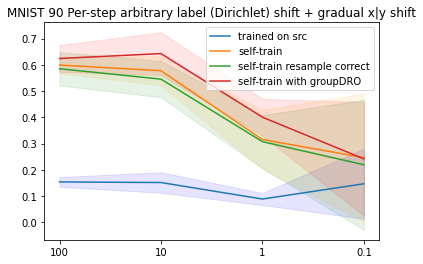

In [60]:
import matplotlib.pyplot as plt

x_label = ["100","10","1","0.1"]
plt.plot(x_label,means[:,0],label="trained on src")
plt.fill_between(x_label,lower_all[:,0], upper_all[:,0], color='b', alpha=.1)
plt.plot(x_label,means[:,1], label="self-train")
plt.fill_between(x_label,lower_all[:,1], upper_all[:,1], color='orange', alpha=.1)
plt.plot(x_label,means[:,2], label="self-train resample correct")
plt.fill_between(x_label,lower_all[:,2], upper_all[:,2], color='green', alpha=.1)
plt.plot(x_label,means[:,3], label="self-train with groupDRO")
plt.fill_between(x_label,lower_all[:,3], upper_all[:,3], color='red', alpha=.1)
plt.title("MNIST 90 Per-step arbitrary label (Dirichlet) shift + gradual x|y shift")
plt.legend()
plt.show()